In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

warnings.filterwarnings("ignore")
pd.options.display.max_rows = 750
pd.options.display.max_columns = 100

df = pd.read_csv("../input/grunge-bands-dataset/grunge.csv")

### Function for Printing and Saving
* Confusion Matrix

In [2]:
def print_save_confusion_matrix(test, pred, suffix=''):

    cnf_matrix = confusion_matrix(test, pred, labels=['no', 'yes'])

    fig, axe = plt.subplots(figsize=(5,4))
    ax =sns.heatmap(
        pd.DataFrame(cnf_matrix), 
        annot=True, 
        cmap=sns.light_palette("#459e97", as_cmap=True),
        fmt='g',)
    plt.title('Confusion Matrix of '+suffix.title()+' Model', y=1.1)
    ax.set_xticklabels(['no', 'yes'])
    ax.set_yticklabels(['no', 'yes'])
    axe.tick_params(top=True, labeltop=True)
    plt.ylabel('Actual charting')
    plt.xlabel('Predicted charting')
    plt.savefig('/kaggle/working/Confusion Matrix ['+suffix.lower()+'].png', dpi=300, bbox_inches='tight')
    plt.show()

# 1. Preprocessing

### Creating the target variable `on_chart`
For songs that have not reached any postition on Billboard top lists, column `on_chart` will be an empty string.<br>
Otherwise, column will contain concatenated strings from all Billboard top lists.

In [3]:
df['on_chart'] = df.iloc[:,33:].replace(np.nan, '').astype(str).apply(''.join, axis=1).str.strip()

# If column `on_chart` contains empty string - label `no`
# Otherwise - label `yes`
df['on_chart'] = ['yes'  if x != '' else 'no' for x in df['on_chart']]

# # Removing all Billboard top lists columns.
df.drop(df.columns[33:97], axis=1, inplace=True)

print(df['on_chart'].value_counts())
print(df['on_chart'].value_counts(normalize=True))

on_chart
no     644
yes     63
Name: count, dtype: int64
on_chart
no     0.910891
yes    0.089109
Name: proportion, dtype: float64


### Creating new index as `track_name` + `album_name`

In [4]:
df['id'] = df.iloc[:,[0,1]].apply(', '.join, axis=1)
print(f"# Observations: {df.shape[0]}")
print(f"# Unique id: {len(df['id'].unique())}")
df.drop(['track_name','album_name'], axis=1, inplace=True)
df.set_index('id', inplace=True)

# Observations: 707
# Unique id: 707


In [5]:
df.sample()

,album_type,duration,release_year,artists,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,producers,writers,track_composers,track_genres,track_styles,track_moods,track_themes,album_duration,album_genres,album_styles,album_recording_date,album_recording_location,album_moods,album_themes,album_rating,on_chart
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Endless, Nameless, Live At The Paramount",live album,384,2011,Nirvana,0.000097,0.331,0.936,0.694,9,0.638,-6.774,0,0.193,135.702,4,0.332,NaN,NaN,"Kurt Cobain, Dave Grohl, Krist Novoselic",Pop/Rock,"Alternative Pop/Rock, Alternative/Indie Rock, ...","Aggressive, Angst-Ridden, Cathartic, Fiery, In...","Cool & Cocky, Guys Night Out, Late Night",01:06:37,Pop/Rock,"Alternative/Indie Rock, Grunge, Indie Rock",NaN,NaN,"Aggressive, Cathartic, Fiery, Intense, Rebelli...","Empowerment, Revolution, Feeling Blue, Freedom...",4.0,no


### Isolating  numerical columns

In [6]:
data = df
data = data.iloc[:,np.r_[1:3,4:16,30:32]]
data.head()

,duration,release_year,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,album_rating,on_chart
id,,,,,,,,,,,,,,,,
"Blew, Bleach",174,1989,0.000006,0.411,0.882,0.01470,1,0.2980,-6.618,1,0.0556,129.848,4,0.531,3.5,no
"Floyd The Barber, Bleach",138,1989,0.000788,0.443,0.878,0.56000,8,0.0623,-6.717,0,0.0418,136.567,4,0.683,3.5,no
"About A Girl, Bleach",168,1989,0.000005,0.413,0.875,0.00058,6,0.2090,-7.480,0,0.0310,131.951,4,0.575,3.5,yes
"School, Bleach",162,1989,0.000012,0.210,0.943,0.49300,4,0.0739,-7.656,1,0.0785,164.844,4,0.130,3.5,no
"Love Buzz, Bleach",215,1989,0.000031,0.479,0.865,0.22800,5,0.1820,-8.281,0,0.0339,137.902,4,0.770,3.5,no


### Detecting outliers

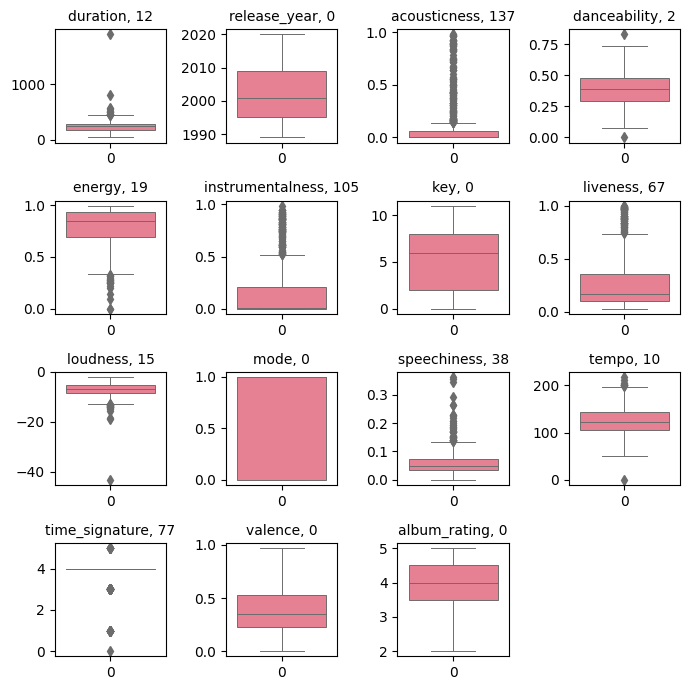

In [7]:
fig, axs = plt.subplots(4, 4, figsize=(7, 7))
axs = axs.flatten()
for i, col in enumerate(data.drop(['on_chart'], axis=1).columns):
    ax = axs[i]
    
    q1 = np.nanpercentile(data[col], 25.)
    q3 = np.nanpercentile(data[col], 75.)
    r = (q3 - q1) * 1.5
    upper, lower = q3 + r, q1 - r
    outliers_index = data[col][(data[col] < lower) | (data[col] > upper)].index.tolist()
    outliers = data[col][(data[col] < lower) | (data[col] > upper)].values

    ax = sns.boxplot(data[col], ax=ax, palette=sns.color_palette('husl'), linewidth=0.7)
    title = col + f', {len(outliers)}'
    ax.set_title(title, fontsize=10)
    
for i in range(len(data.columns)-1, len(axs)):
    fig.delaxes(axs[i])
    
plt.tight_layout()
plt.show()

### Correlation Matrix

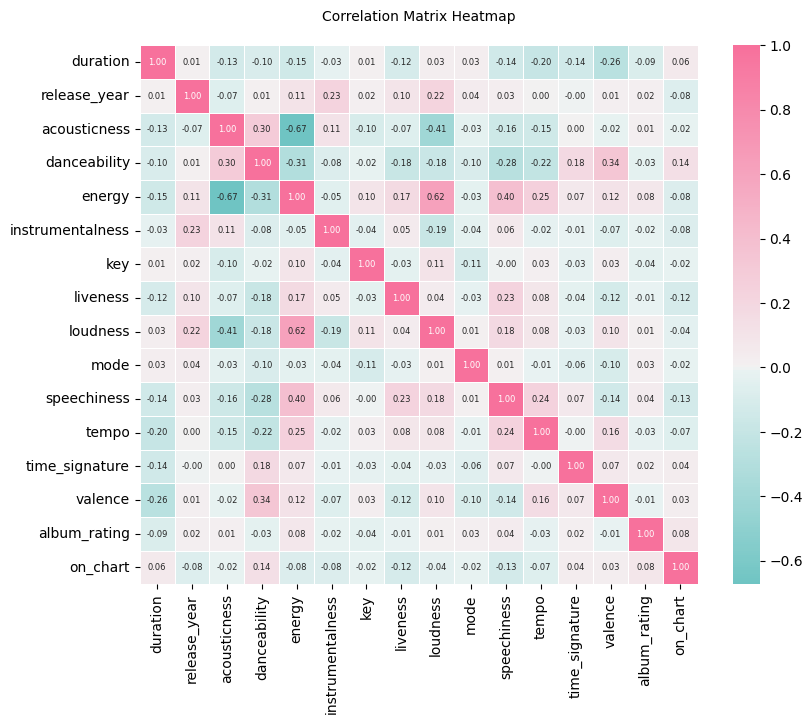

In [8]:
# Transform on_chart to numerical value
data['on_chart'][data['on_chart'] == 'yes'] = 1
data['on_chart'][data['on_chart'] == 'no'] = 0

plt.figure(figsize=(9,7))
ax = sns.heatmap (
    data=data.corr(),
    annot=True,
    annot_kws={'size': 6},
    fmt='.2f',
    cmap=sns.diverging_palette(190, 355, s=90, l=65, sep=1, as_cmap=True),
    linewidths=0.5,
    center=0
)
plt.title('Correlation Matrix Heatmap\n', fontsize=10)
plt.show()

In [9]:
# Selection of features with target correlation higher than 0.05

corr_matrix = data.corr()
cor_target = abs(corr_matrix['on_chart'])
to_drop = cor_target[cor_target<0.1]
data.drop(to_drop.index, axis=1, inplace=True)
data.head()

,danceability,liveness,speechiness,on_chart
id,,,,
"Blew, Bleach",0.411,0.2980,0.0556,0
"Floyd The Barber, Bleach",0.443,0.0623,0.0418,0
"About A Girl, Bleach",0.413,0.2090,0.0310,1
"School, Bleach",0.210,0.0739,0.0785,0
"Love Buzz, Bleach",0.479,0.1820,0.0339,0


### Computing the VIF

In [10]:
# comute_vif funtion from 
# https://towardsdatascience.com/targeting-multicollinearity-with-python-3bd3b4088d0b

def compute_vif(considered_features):
    
    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

considered_features = data.drop('on_chart', axis=1).columns
compute_vif(considered_features).sort_values('VIF', ascending=False)

,Variable,VIF
2,speechiness,1.123246
0,danceability,1.100645
1,liveness,1.073967


### Box-Tidwell Test

In [11]:
data.head()

,danceability,liveness,speechiness,on_chart
id,,,,
"Blew, Bleach",0.411,0.2980,0.0556,0
"Floyd The Barber, Bleach",0.443,0.0623,0.0418,0
"About A Girl, Bleach",0.413,0.2090,0.0310,1
"School, Bleach",0.210,0.0739,0.0785,0
"Love Buzz, Bleach",0.479,0.1820,0.0339,0


In [12]:
# Code from https://github.com/sandipanpaul21/Logistic-regression-in-python/blob/main/07_LR_Assumptions.ipynb
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families

# Consider only continous predictors
data.head()
test_data = data[['danceability','liveness', 'speechiness','on_chart']]

# Transform continous variables X * ln(X)
for col in test_data.drop('on_chart', axis=1).columns:
    test_data.drop(test_data[test_data[col] == 0].index, inplace=True)
    test_data[f'{col}_t'] = test_data[col].apply(lambda x: x * np.log(x))
test_data.dropna(axis=0, inplace=True)

# Split and add constant
X = test_data.drop('on_chart', axis=1)
y = test_data['on_chart']
X = sm.add_constant(X, prepend=False)

# Build model and fit the data
logit_results = GLM(y.astype(float), X.astype(float), family=families.Binomial()).fit()

# Display summary results
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               on_chart   No. Observations:                  706
Model:                            GLM   Df Residuals:                      699
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -196.38
Date:                Sat, 31 Aug 2024   Deviance:                       392.76
Time:                        17:52:17   Pearson chi2:                     693.
No. Iterations:                     8   Pseudo R-squ. (CS):            0.04421
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
danceability       2.2758      1.335      1.

# 2. Building Base Model 

### Splitting the data

In [13]:
from sklearn.model_selection import train_test_split

data['on_chart'][data['on_chart'] == 1] = 'yes'
data['on_chart'][data['on_chart'] == 0] = 'no'

X = data.drop('on_chart', axis=1) # Features
y = data['on_chart'] # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2024)

X_train.head()

,danceability,liveness,speechiness
id,,,
"You Are, Riot Act",0.609,0.107,0.0256
"Spank Thru, Live At Reading",0.265,0.544,0.0591
"No Excuses, Jar Of Flies",0.527,0.070,0.0323
"Check My Brain, Black Gives Way to Blue",0.441,0.723,0.0462
"665, Ultramega OK",0.497,0.148,0.0536


### Feature scaling

In [14]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Training base model

In [15]:
logreg = LogisticRegression(class_weight='balanced', random_state=23)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test_scaled)

### Evaluation of Base Model

Accuracy: 0.51
Precision: 0.93
Recall: 0.5


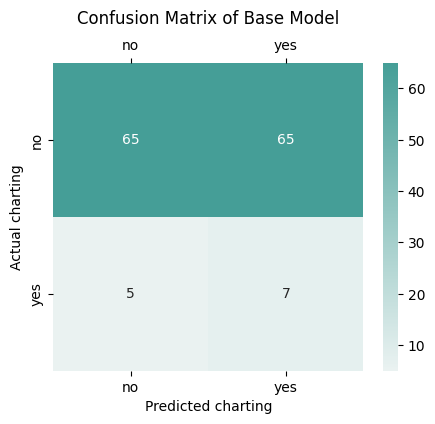

In [16]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='no')
recall = recall_score(y_test, y_pred, pos_label='no')

print(f'Accuracy: {round(accuracy, 2)}')
print(f'Precision: {round(precision, 2)}')
print(f'Recall: {round(recall, 2)}')

print_save_confusion_matrix(y_test, y_pred, suffix='base')

# 3. Hyperparameter Tuning

### Grid Search Cross Validation

In [17]:
param_grid = {
    "penalty" : [None, 'l1','l2', 'elasticnet'],
    "solver" : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, 
                           cv=10, n_jobs=-1, verbose=1, scoring='accuracy')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")


Fitting 10 folds for each of 24 candidates, totalling 240 fits
Best parameters: {'penalty': None, 'solver': 'lbfgs'}


### Evaluation of Tuned Model 

Accuracy: 0.56
Precision: 0.94
Recall: 0.56


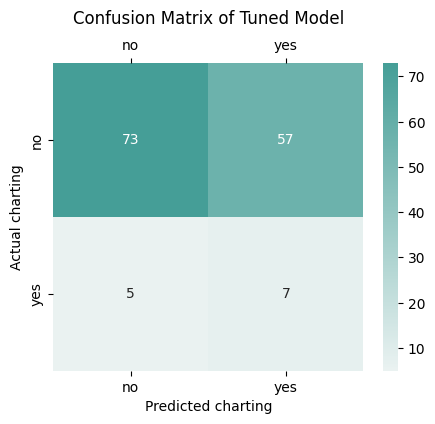

In [18]:
best_logreg = grid_search.best_estimator_
best_logreg.fit(X_train_scaled, y_train)
y_pred = best_logreg.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='no')
recall = recall_score(y_test, y_pred, pos_label='no')

print(f'Accuracy: {round(accuracy, 2)}')
print(f'Precision: {round(precision, 2)}')
print(f'Recall: {round(recall, 2)}')

print_save_confusion_matrix(y_test, y_pred, suffix='tuned')